# Machine Learning: Data Pre-Processing



 Different kinds of pre-processing.
 
 - kernel density 
 - normalisation 
 - principle component analysis / independent component analysis (PCA / ICA)
 - dimensionality reduction 
 - whitening (why would you do that?) i.e. removing correlation by applying rotation


## Kernel Density Estimation

Kernel density estimation is a way of estimating the probability distribution generating some data. It is non-parametric, meaning it doesn't assume a specific functional form. Basically, the function value (probability density) at each point is estimated by using nearby data points. It's a little bit like a continuous version of binning data. It is computed using a kernel function $K$, and with respect to a "bin width" $h$ (actually called *bandwidth*) like this: 

$$ p(x) = \frac{1}{Nh} \sum_{i=1}^{N} \frac{K(x - x_i)}{h} $$

where $N$ is the number of data points at $x_i$ is the $i$'th data point. Very often the $K$ function is the Gaussian function (i.e. people use a "Gaussian kernel"), and in that case you can think of it like this. Data points that are further away make less and less contribution to the sum, since the Gaussian will return a small value. Data points that are close by (within one or two $h$'s) contribute to the sum, and the more close-by data points there are, the larger the value will be (like a bin!). Note how in the formula, the value fed to the kernel function is the distance from the data point **relative to the bandwidth** $h$ 


#### 1) Generate some random data and put it in a histogram (standard binning)

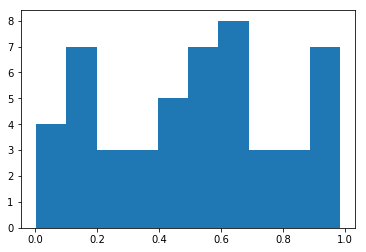

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline 

n = 50 # number of data points 
randoms = np.random.rand(n)
# hist, sist = np.histogram(randoms)
plt.hist(randoms, 10)
plt.show()

#### 2) Now use kernel density estimation with a Gaussian kernel. 

For each value on the x axis, compute the kernel density estimate (i.e. estimated probability value) by comparing it with nearby data points. If there are many data point nearby, that will make the probability higher, and if it is quite isolated that will make it lower. 

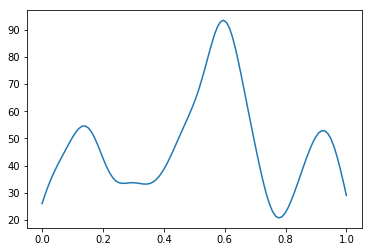

In [2]:
def gaussian_kde(x, data, dim = 1, h = 0.05):
    return sum( (1/h)**dim*st.norm.pdf((x - data)/h) )
x = np.linspace(0,1,100)
y = [gaussian_kde(val, randoms) for val in x]
plt.plot(x,y)

#### 3) Now compare using small vs large bandwidth

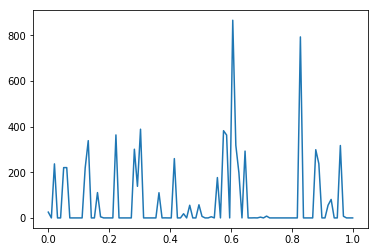

In [3]:
width = 0.001
x = np.linspace(0,1,100)
y = [gaussian_kde(xval, randoms, h=width) for xval in x]
plt.plot(x,y)

Using a small width the data looks very noisy (as in histogram case). Basically, you can say it's just like keeping the data itself without doing anything to it. What's the point, yknow?  

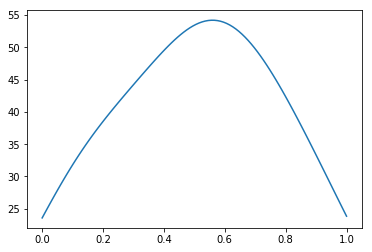

In [4]:
width = 0.2
x = np.linspace(0,1,100)
y = [gaussian_kde(xval, randoms, h=width) for xval in x]
plt.plot(x,y)

Using a large bandwidth makes the data look very smooth. It's a bit like putting all the data into a single bin. If the bandwidth is large enough, all datasets basically look the same. What's the point 'o that?  

## Normalisation, Whitening, PCA 

### Normalization

Normalization is just making the data have zero mean and standard deviation/ variance of 1. This just ensures that all the dimensions of the data are scaled in the same way. So it's just 
- subtract off the mean 
- divide by the standard deviation

#### 1) import the dataset

<class 'numpy.ndarray'>


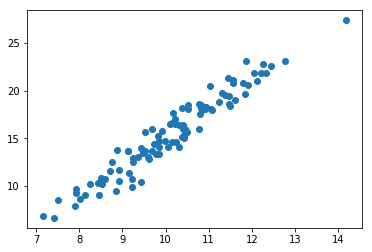

In [5]:
import scipy.io as io
data = io.loadmat("sem9_q1_data.mat")['data']
print(type(data))
X = data[:,0]
Y = data[:,1]
plt.scatter(X,Y)

#### 2) normalize the data

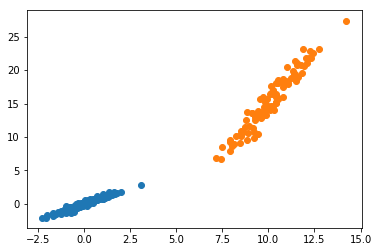

In [6]:
Xm = (X - np.mean(X))/np.std(X)
Ym = (Y - np.mean(Y))/np.std(Y)
plt.scatter(Xm,Ym)
plt.scatter(X,Y)

We have shifted and scaled the data. As you can see, the normalized data is still correlated. Whitening removes the correlation.  

### Whitening 

Whitening is a method for decorrelating data. It find the principle eigenvectors of the demeaned data, applied a rotation to decorrelate, and normalizes. 

#### 1) Compute the covariance matrix of the data (tells you correlations in different directions)

Let's work out the covariance matrix by hand, instead of getting numpy to do it for us, so we know what's going on. The correlation between two sets of data is defined as: 

$$ corr_{XY} = \frac{1}{N} \sum_{i = 1}^N (x_i - \bar{x}) (y_i - \bar{y})$$

Notice that when X = Y this becomes the variance. So it's a generalisation of variance. It tell you how much they are correlated because: if x being greater than the means tends on average to correspond with y being greater than the mean, and vice versa for less than the mean, we will tend to get lots of positive contributions to the sum. If they are anti-correlated (when one is above the other tends to be below), we will tend to get negative contributions to the sum. If there is absolutely no pattern, there is no more reason to get a positive than a negative contribution, so we get something close to zero. 

In [7]:
n = len(X)
corXX = (1/n)*np.dot(X - np.mean(X), X - np.mean(X))
corXY = (1/n)*np.dot(X - np.mean(X), Y - np.mean(Y))
corYY = np.var(Y)
covariance = np.array([[corXX, corXY], [corXY, corYY] ])
covariance

array([[ 1.722105  ,  5.34104265],
       [ 5.34104265, 17.72717759]])

It seems like numpy's calculation is slightly different for some reason... don't know why. This is because by default numpy divides by ($n-1$) instead of $n$. If you put `bias = true` it divides by $n$. 

In [8]:
covariance = np.cov(X,Y) # , bias = True)
covariance 

array([[ 1.7395    ,  5.39499258],
       [ 5.39499258, 17.90623999]])

Notice there's a significant correlation (as we saw in the plots) between the two variables. 

#### 2) Get the eigenvalues and eigenvectors of the covariance matrix

In [9]:
e, U = np.linalg.eig(covariance)
print("eigenvalues: [%f %f]" % (e[0], e[1]))
print("eigenvectors: ")
print(U)

eigenvalues: [0.104495 19.541245]
eigenvectors: 
[[-0.95701658 -0.29003321]
 [ 0.29003321 -0.95701658]]


Let's plot these eigenvectors over the (demeaned) data to see

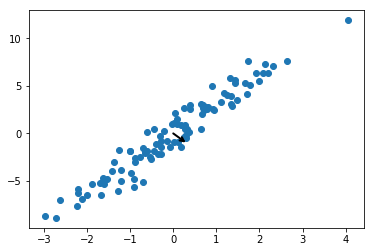

In [10]:
Xm = (X - np.mean(X))
Ym = (Y - np.mean(Y))
plt.scatter(Xm,Ym)
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# draw_vector([0,0], U[0])
draw_vector([0,0], U[1])

Multiplying the data by the transformation defined by the eigenvectors actually rotates, and thus decorelates the data. Checkit out: 

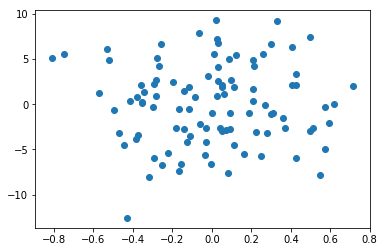

In [11]:
decorrelated = np.matmul((data - np.mean(data,0)), U)
plt.scatter(decorrelated[:,0], decorrelated[:,1])

Here I applied the transformation the the "demeaned" data. If we compute the covariance of this, we should see that they aren't correlated (as we can already see in the plot). 

In [12]:
covar = np.cov(decorrelated[:,0], decorrelated[:,1])
covar

array([[ 1.04494856e-01, -1.55950073e-15],
       [-1.55950073e-15,  1.95412451e+01]])

Indeed, the numbers on the off-diagonal are vanishingly small. You'll notice that the numbers on the diagonal are exactly the eigenvalues of the original covariance matrix we calculated! So, we've successfully put the covariance matrix in diagonal form, with the eigenvalues on the diag...

#### 3) Finally, we do the full "whitening" operation on the data

$$ \Lambda ^ {-1/2}  U^T (X - \bar{X})$$

i.e.
1. demean the data
2. rotate using eigenvalue transformation (decorrelating data) 
3. divide by the square root of the eigenvalues, essentially normalizing the data

[-10, 25, -10, 25]

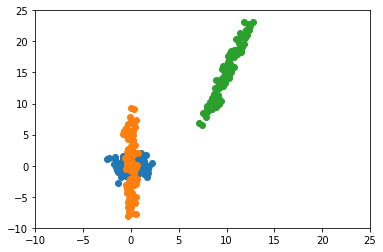

In [13]:
Lambda = np.diag(1/np.sqrt(e))
white = np.matmul(np.matmul((data - np.mean(data,0)), U),Lambda)
plt.scatter(white[:,0], white[:,1])
plt.scatter(decorrelated[:,0], decorrelated[:,1])
plt.scatter(data[:,0], data[:,1])
plt.axis([-10, 25, -10, 25])

Green = original data 

Orange = rotated to decorrelate 

Blue = final data

### Principle Component Analysis (PCA)

PCA is an algorithm to reduce the dimensionality of data by spotting implicit correlation between dimensions..? 

As far as I understand, PCA also finds the eigenvectors like we manually did, and depending on the number of principle components specified, it drops the components with the least amount of variance. 

In [14]:
from sklearn.decomposition import PCA 

In [15]:
pca = PCA(n_components = 2)
pca.fit(data)
print(pca.components_)

[[ 0.29003321  0.95701658]
 [ 0.95701658 -0.29003321]]
